# Effective MLOps: Model Development

Full Analysis report available on [Weights and Biases profile.](https://api.wandb.ai/links/pierpaolo28/0dc2sw37)

## Setup

In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
from ipywidgets import *
import warnings
warnings.filterwarnings('ignore')
wandb.login()
sns.set()

wandb: Currently logged in as: pierpaolo28. Use `wandb login --relogin` to force relogin


In [2]:
# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
np.random.seed(seed)

run = wandb.init(
    # Set the project where this run will be logged
    project="EffectiveMLOps with W&B")

## Data Preparation

In [3]:
# flatten 28*28 images to a 784 vector for each image
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor
    transforms.Lambda(lambda x: x.view(-1))  # flatten into vector
])

In [4]:
trainset = MNIST(".", train=True, download=True, transform=transform)
testset = MNIST(".", train=False, download=True, transform=transform)

artifact = wandb.Artifact('mnist', type='dataset')
artifact.add_dir('MNIST/raw') 
run.log_artifact(artifact)

wandb: Adding directory to artifact (./MNIST/raw)... Done. 0.1s


In [5]:
# create data loaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

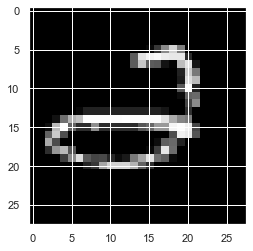

In [6]:
images, labels = next(iter(trainloader))
plt.imshow(images[0].reshape(28,28), cmap="gray")

In [7]:
classes = (labels.unique().numpy())

columns=['image','label']
data = []

for i, batch in enumerate(trainloader, 0):
    inputs, labels = batch[0], batch[1]
    for j, image in enumerate(inputs,0):
        data.append([wandb.Image(image.reshape(28,28)),classes[labels[j].item()]])
    break

table= wandb.Table(data=data, columns=columns)
run.log({"mnist_images": table})

## Model Preparation

In [8]:
# define baseline model
class BaselineModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BaselineModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        return out

In [9]:
def train_model(model, criterion, optimizer, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    wandb.watch(model, criterion, log="all")

    loss_plot, acc_plot = [], []
    val_loss_plot, val_acc_plot = [], []
    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels.long())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data.long())

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                loss_plot.append(epoch_loss)
                acc_plot.append(epoch_acc)
            else:
                val_loss_plot.append(epoch_loss)
                val_acc_plot.append(epoch_acc)

            wandb.log({'phase': phase, 'epoch': epoch, 'loss': epoch_loss, 'acc': epoch_acc})

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best val Loss: {:4f}'.format(best_loss))

    # loading best model weights
    model.load_state_dict(best_model_wts)
    # ... Serialize your model
    torch.save(best_model_wts, "model.pt")
    # ... Create a Model Version
    art = wandb.Artifact(f'mnist-nn-{wandb.run.id}', type="model")
    # ... Add the serialized files
    art.add_file("model.pt", "model.pt")
    # (optional) Log training metrics
    wandb.log({"best_acc": best_acc, "best_loss": best_loss})
    # ... Log the Version
    # If the model is the best model so far,
    #  add "best" to the aliases
    wandb.log_artifact(art, aliases=["latest", "best"])
    train_val_plot(loss_plot, val_loss_plot, acc_plot, val_acc_plot)
    return model

In [10]:
def train_val_plot(loss_plot, val_loss_plot, acc_plot, val_acc_plot):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    ax[0].plot(loss_plot, label="Training Loss")
    ax[0].plot(val_loss_plot, label="Test Loss")
    ax[0].legend(fontsize=18)
    ax[0].grid(True)
    ax[0].set_title("Training/Test Loss", fontsize=20);
    ax[0].set_xlabel("Epoch", fontsize=18);
    ax[0].set_ylabel("Loss", fontsize=18);
    ax[1].plot(acc_plot, label="Training accuracy")
    ax[1].plot(val_acc_plot, label="Test accuracy")
    ax[1].legend(fontsize=18)
    ax[1].grid(True)
    ax[1].set_title("Training/Test Accuracy", fontsize=20);
    ax[1].set_xlabel("Epoch", fontsize=18);
    ax[1].set_ylabel("Accuracy (%)", fontsize=18);
    plt.savefig("Training.png", format='png', dpi=1200)
    wandb.log({"training_report": wandb.Image("Training.png")})
    plt.show()

## Model Building

BaselineModel(
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=10, bias=True)
)
Training complete in 0m 46s
Best val Acc: 0.979200
Best val Loss: 0.071220


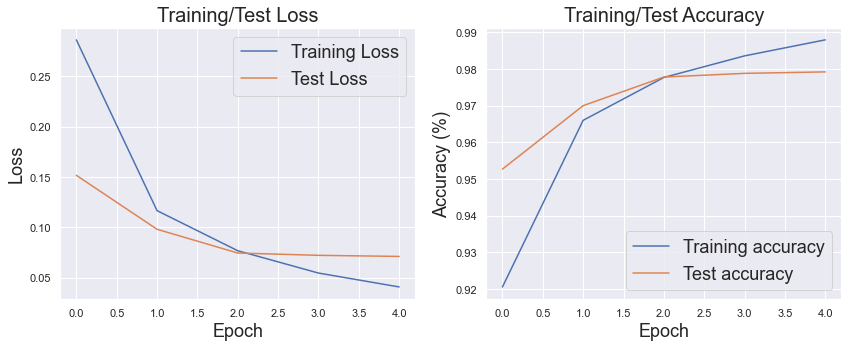

BaselineModel(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=10, bias=True)
)
Training complete in 0m 48s
Best val Acc: 0.980400
Best val Loss: 0.066692


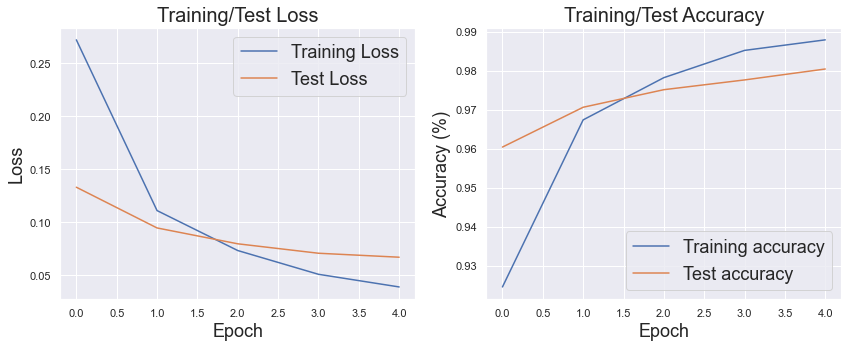

In [11]:
import time
import copy

dataloaders = {'train': trainloader, 'val': testloader}
dataset_sizes = {'train': len(trainloader.dataset), 'val': len(testloader.dataset)}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for i in range(300, 500, 100):
    model = BaselineModel(784, i, 10)
    print(model)
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.Adam(model.parameters())
    train_model(model, criterion, optimizer_ft, num_epochs=5)

## Model Evaluation

In [12]:
def test_model(model, testloader):
    model.eval()
    # Computing the model accuracy on the test set
    correct, total = 0, 0
    for x, y in testloader:
        outputs = model(x)
        winners = outputs.argmax(dim=1)
        count = [1 for i, j in zip(winners, y.long()) if i == j]
        correct += sum(count)
        total += len(y)
    print('Test Accuracy: %2.2f %%' % ((100.0 * correct) / total))
    
test_model(model, testloader)

Test Accuracy: 98.04 %


In [13]:
def confusion_matrix(data, nb_classes):
    df_cm = pd.DataFrame(data, 
                          range(nb_classes), range(nb_classes))
    plt.figure(figsize=(10,7))
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap='Blues', 
                fmt='g')
    plt.title("Confusion Matrix", fontsize = 20)
    plt.xlabel("Predicted Output", fontsize = 18)
    plt.ylabel("Expected Output", fontsize = 18)
    plt.savefig("confusion_matrix.png", format='png', dpi=1200)
    wandb.log({"confusion_matrix": wandb.Image("confusion_matrix.png")})
    plt.show()

# ! pip install PTable
# from prettytable import PrettyTable
def summary_table(data, nb_classes):
    p = PrettyTable(data)
    p.title = 'Predicted Output'
    for head, row in zip([i for i in range(0, nb_classes)], data):
        r = [head]
        r.extend(row)
        p.add_row(r)
    l = ['    ']
    l.extend([i for i in range(0, nb_classes)])
    p.field_names = l
    print(p)

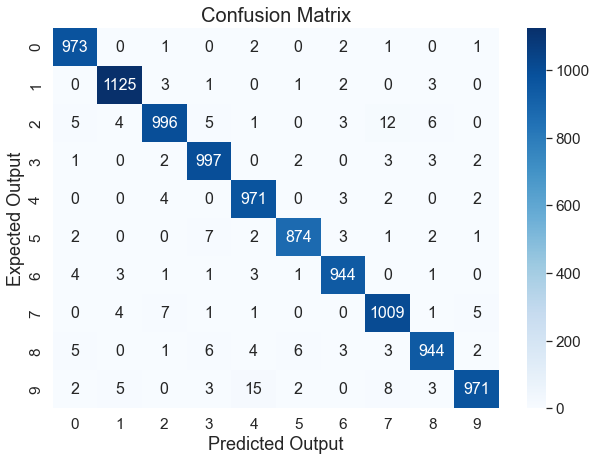

Class: 0 Accuracy: 99.28571
Class: 1 Accuracy: 99.11894
Class: 2 Accuracy: 96.51163
Class: 3 Accuracy: 98.71287
Class: 4 Accuracy: 98.87984
Class: 5 Accuracy: 97.98206
Class: 6 Accuracy: 98.53862
Class: 7 Accuracy: 98.15175
Class: 8 Accuracy: 96.919914
Class: 9 Accuracy: 96.233894
Overall Accuracy:  98.03352 %


In [14]:
def acc_per_class(model, testloader, nb_classes):
    model.eval()
    confusion_mat = torch.zeros(nb_classes, nb_classes)
    class_correct = torch.zeros(10)
    class_total = torch.zeros(10)
    total = 0
    for inputs, labels in testloader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), preds.view(-1)):
              confusion_mat[t.long(), p.long()] += 1

    confusion_matrix(confusion_mat.data.cpu().numpy(), nb_classes)

    per_class_acc = 100*confusion_mat.diag()/confusion_mat.sum(1)
    for i, j in enumerate(per_class_acc.data.cpu().numpy()):
        print("Class:", i, "Accuracy:", j)
    acc = torch.mean(per_class_acc).data.cpu().numpy()
    print("Overall Accuracy: ", acc, "%")

acc_per_class(model, testloader, 10)

## Improving our baseline model

In [15]:
# define deeper model
class DeeperModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(DeeperModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        return out

DeeperModel(
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=10, bias=True)
)
Training complete in 1m 30s
Best val Acc: 0.980300
Best val Loss: 0.083067


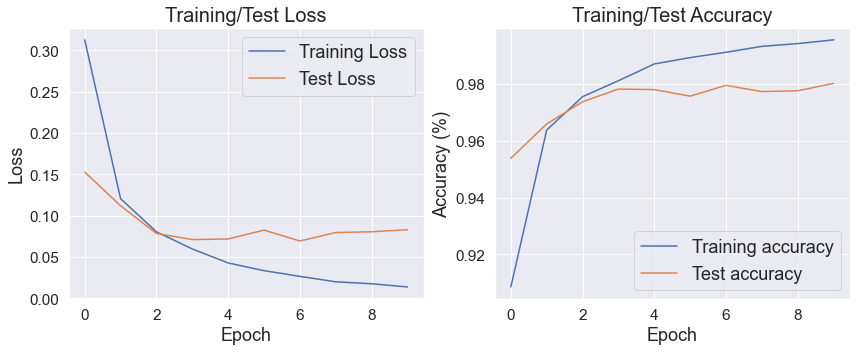

DeeperModel(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=10, bias=True)
)
Training complete in 1m 27s
Best val Acc: 0.979800
Best val Loss: 0.063409


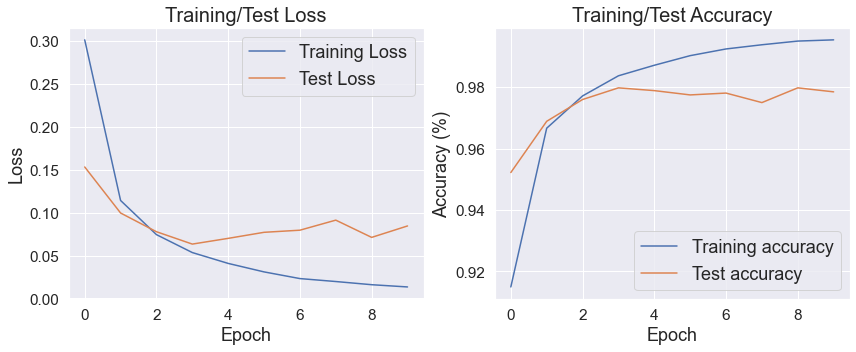

Test Accuracy: 97.98 %


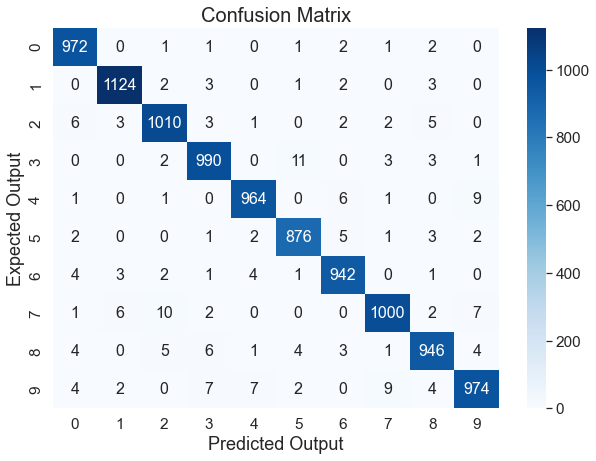

Class: 0 Accuracy: 99.18367
Class: 1 Accuracy: 99.03084
Class: 2 Accuracy: 97.86822
Class: 3 Accuracy: 98.0198
Class: 4 Accuracy: 98.16701
Class: 5 Accuracy: 98.206276
Class: 6 Accuracy: 98.32986
Class: 7 Accuracy: 97.27627
Class: 8 Accuracy: 97.12526
Class: 9 Accuracy: 96.53122
Overall Accuracy:  97.97383 %


In [16]:
for i in range(300, 500, 100):
    model = DeeperModel(784, i, 30, 10)
    print(model)
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.Adam(model.parameters())
    train_model(model, criterion, optimizer_ft, num_epochs=10)
test_model(model, testloader)
acc_per_class(model, testloader, 10)

## Hyperparameter Tuning

In [17]:
config = wandb.config
config.learning_rate = 0.2
config.momentum = 0.5

sweep_config = {
                'method': 'grid',
                'metric': {'goal': 'minimize', 'name': 'loss'},
                'parameters': {
                    'batch_size': {'value': 16},
                    'epochs': {'value': 5},
                    'fc_layer_size': {'values': [32, 64]},
                    'learning_rate': {'values': [0.2, 0.3]},
                    'optimizer': {'values': ['adam', 'sgd']}
                }
 }

sweep_id = wandb.sweep(sweep_config, project="EffectiveMLOps with W&B")

Create sweep with ID: 6dss5xcl
Sweep URL: https://wandb.ai/pierpaolo28/EffectiveMLOps%20with%20W%26B/sweeps/6dss5xcl


In [18]:
def train(config=None):

    if __name__ == "__main__":
        with wandb.init(project="EffectiveMLOps with W&B", config=config):
            config = wandb.config

            transform = transforms.Compose([
                transforms.ToTensor(),  # convert to tensor
                transforms.Lambda(lambda x: x.view(-1))  # flatten into vector
            ])
            trainset = MNIST(".", train=True, download=True, transform=transform)
            testset = MNIST(".", train=False, download=True, transform=transform)
            trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
            testloader = DataLoader(testset, batch_size=128, shuffle=True)
            model = DeeperModel(784, 50, 30, 10)
            model.to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer_ft = optim.Adam(model.parameters(), lr=config.learning_rate)


            if config.optimizer == "sgd":
                optimizer_ft = optim.SGD(model.parameters(),
                                      lr=config.learning_rate, momentum=0.9)
            elif optimizer_ft == "adam":
                optimizer_ft = optim.Adam(model.parameters(),
                                       lr=config.learning_rate)

            wandb.watch(model, criterion, log="all")

            for epoch in range(config.epochs):  # loop over the dataset multiple times

                running_loss = 0.0

                for i, data in enumerate(trainloader, 0):

                    inputs, labels = data[0].to(device), data[1].to(device)
                    optimizer_ft.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer_ft.step()
                    running_loss += loss.item()

                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / len(trainloader)))

                wandb.log({'epoch': epoch + 1, 'loss': running_loss / len(trainloader)})

            print('Finished Training')
        
wandb.agent(sweep_id, function=train, count=3)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Waiting for W&B process to finish... (success).
wandb: 
wandb: Run history:
wandb:       acc ‚ñÇ‚ñÑ‚ñÜ‚ñá‚ñá‚ñá‚ñá‚ñÇ‚ñÜ‚ñÜ‚ñÜ‚ñá‚ñá‚ñá‚ñÑ‚ñÖ‚ñÜ‚ñÜ‚ñá‚ñá‚ñà‚ñÜ‚ñá‚ñà‚ñà‚ñá‚ñá‚ñÅ‚ñÜ‚ñÜ‚ñÜ‚ñá‚ñá‚ñá‚ñá‚ñà‚ñà‚ñÜ‚ñá‚ñá
wandb:  best_acc ‚ñÅ‚ñà‚ñá‚ñÑ
wandb: best_loss ‚ñÑ‚ñÇ‚ñà‚ñÅ
wandb:     epoch ‚ñÅ‚ñÅ‚ñÇ‚ñÉ‚ñÉ‚ñÉ‚ñÑ‚ñÅ‚ñÇ‚ñÇ‚ñÉ‚ñÉ‚ñÑ‚ñÑ‚ñÅ‚ñÇ‚ñÉ‚ñÉ‚ñÉ‚ñÑ‚ñÖ‚ñÖ‚ñÜ‚ñÜ‚ñá‚ñá‚ñà‚ñÅ‚ñÇ‚ñÇ‚ñÉ‚ñÉ‚ñÑ‚ñÑ‚ñÖ‚ñÜ‚ñÜ‚ñÜ‚ñá‚ñà
wandb:      loss ‚ñà‚ñÑ‚ñÉ‚ñÇ‚ñÇ‚ñÇ‚ñÇ‚ñá‚ñÉ‚ñÉ‚ñÉ‚ñÇ‚ñÇ‚ñÇ‚ñÑ‚ñÑ‚ñÉ‚ñÉ‚ñÇ‚ñÇ‚ñÅ‚ñÉ‚ñÇ‚ñÅ‚ñÅ‚ñÉ‚ñÉ‚ñà‚ñÉ‚ñÉ‚ñÇ‚ñÇ‚ñÇ‚ñÇ‚ñÇ‚ñÅ‚ñÅ‚ñÉ‚ñÇ‚ñÉ
wandb: 
wandb: Run summary:
wandb:       acc 0.9785
wandb:  best_acc 0.9798
wandb: best_loss 0.06341
wandb:     epoch 9
wandb:      loss 0.08456
wandb:     phase val
wandb: 
wandb: üöÄ View run restful-dew-29 at: https://wandb.ai/pierpaolo28/EffectiveMLOps%20with%20W%26B/runs/czw7eii1
wandb: Synced 5 W&B file(s), 7 media file(s), 69 artifact file(s) and 0 other file(s)

[1,   469] loss: 2.440
[2,   469] loss: 2.310
[3,   469] loss: 2.312
[4,   469] loss: 2.313
[5,   469] loss: 2.312
Finished Training


wandb: Agent Starting Run: o0basekk with config:
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.2
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


[1,   469] loss: 0.367
[2,   469] loss: 0.169
[3,   469] loss: 0.142
[4,   469] loss: 0.118
[5,   469] loss: 0.113
Finished Training


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f4rov9pn with config:
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


[1,   469] loss: 2.431
[2,   469] loss: 2.100
[3,   469] loss: 2.304
[4,   469] loss: 2.317
[5,   469] loss: 2.319
Finished Training


Error in callback <function _WandbInit._pause_backend at 0x7f794fb0d700> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe